In [158]:
import os, itertools, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


## 讀檔案

In [159]:
file = open('./test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_test = np.ndarray((0, 2))
y_test = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X_test = np.vstack((X_test, np.array(row[0:2])))
  y_test = np.append(y_test, y_mapping[row[2]])
Xtest = X_test.astype(np.float)
ytest = y_test.astype(np.float)
file.close()


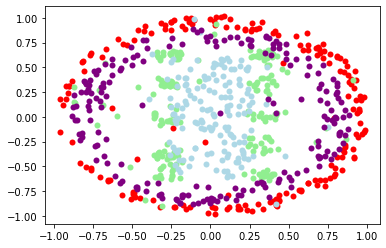

In [160]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

## GridSearchCV StratifiedKFold KNN

In [161]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors':[1, 2, 3, 4, 5]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.91 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.85 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.85 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.81 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.78 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.84 (5x10 nested CV)


## Test accuracy

In [162]:
pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=3)]])

pipe.fit(X, y)

# performance reporting
y_pred = pipe.predict(Xtest)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5*10 nested CV)' % 
      (accuracy_score(ytest, y_pred), 3))

Test accuracy: 0.79 (n_neighbors=3 selected by 5*10 nested CV)


## GridSearchCV StratifiedKFold SVM

In [163]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel='rbf', random_state=1, gamma=0.2, probability=True)]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__C':[1, 100, 1000], 'clf__gamma':[0.1, 0.2, 0.4, 0.6, 0.8]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (C=%d gamma=%.f selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__C'], gs.best_params_['clf__gamma']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (C=1000 gamma=0 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.88 (C=1000 gamma=0 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.87 (C=100 gamma=0 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.81 (C=100 gamma=0 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.84 (C=1000 gamma=0 selected by inner 10-fold CV)

Test accuracy: 0.86 (5x10 nested CV)


## Test accuracy

In [164]:
pipe = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel='rbf', random_state=1, gamma='auto', C=1000, probability=True)]])

pipe.fit(X, y)

# performance reporting
y_pred = pipe.predict(Xtest)
print('Test accuracy: %.2f (C=%d selected by 5*10 nested CV)' % 
      (accuracy_score(ytest, y_pred), 1000))

Test accuracy: 0.84 (C=1000 selected by 5*10 nested CV)


## GridSearchCV StratifiedKFold RandomForest

In [165]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['clf', RandomForestClassifier(criterion='entropy', random_state=1,n_jobs=2)]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_estimators':[50, 100, 150, 200, 250], 'clf__min_samples_leaf':[1,5,10,50,100,200,500]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_estimators=%d min_samples_leaf=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_estimators'], gs.best_params_['clf__min_samples_leaf']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.84 (n_estimators=100 min_samples_leaf=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.87 (n_estimators=200 min_samples_leaf=1 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.84 (n_estimators=50 min_samples_leaf=1 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.84 (n_estimators=250 min_samples_leaf=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.78 (n_estimators=250 min_samples_leaf=1 selected by inner 10-fold CV)

Test accuracy: 0.83 (5x10 nested CV)


## Test accuracy

In [191]:
pipe = Pipeline([['clf', RandomForestClassifier(criterion='entropy', random_state=1,n_jobs=2, n_estimators=250, min_samples_leaf=1)]])

pipe.fit(X, y)

# performance reporting
y_pred = pipe.predict(Xtest)
print('Test accuracy: %.2f (n_estimators=%d, min_samples_leaf=%d selected by 5*10 nested CV)' % 
      (accuracy_score(ytest, y_pred), 250, 1))

Test accuracy: 0.81 (n_estimators=250, min_samples_leaf=1 selected by 5*10 nested CV)


## Voting

In [167]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 5, random_state = 1, solver = "liblinear")]])
pipe2 = Pipeline([['clf', RandomForestClassifier(criterion='entropy', random_state=1,n_jobs=2, n_estimators=250, min_samples_leaf=1)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 3)]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel='rbf', random_state=1, gamma='auto', C=1000, probability=True)]])

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c, d in list(itertools.permutations(range(0,4))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3), ('svc', pipe4)], 
                           voting='soft', weights=[a,b,c,d])
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c,d), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c, d), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2, 3): 0.866 (+/- 0.049)
(0, 1, 3, 2): 0.859 (+/- 0.043)
(0, 2, 1, 3): 0.869 (+/- 0.042)
(0, 2, 3, 1): 0.859 (+/- 0.049)
(0, 3, 1, 2): 0.864 (+/- 0.033)
(0, 3, 2, 1): 0.856 (+/- 0.037)
(1, 0, 2, 3): 0.864 (+/- 0.039)
(1, 0, 3, 2): 0.860 (+/- 0.037)
(1, 2, 0, 3): 0.873 (+/- 0.046)
(1, 2, 3, 0): 0.852 (+/- 0.046)
(1, 3, 0, 2): 0.860 (+/- 0.043)
(1, 3, 2, 0): 0.851 (+/- 0.042)
(2, 0, 1, 3): 0.871 (+/- 0.037)
(2, 0, 3, 1): 0.850 (+/- 0.042)
(2, 1, 0, 3): 0.869 (+/- 0.053)
(2, 1, 3, 0): 0.843 (+/- 0.052)
(2, 3, 0, 1): 0.843 (+/- 0.038)
(2, 3, 1, 0): 0.842 (+/- 0.034)
(3, 0, 1, 2): 0.863 (+/- 0.036)
(3, 0, 2, 1): 0.852 (+/- 0.042)
(3, 1, 0, 2): 0.867 (+/- 0.052)
(3, 1, 2, 0): 0.835 (+/- 0.050)
(3, 2, 0, 1): 0.846 (+/- 0.046)
(3, 2, 1, 0): 0.844 (+/- 0.038)

Best (1, 2, 0, 3): 0.873


In [180]:
clf_ = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3), ('svc', pipe4)], 
                           voting='soft', weights=[1,2,0,3])
clf_.fit(X,y)
print('[Voting] accuracy-test = %.3f' % (clf_.score(Xtest,ytest)))

[Voting] accuracy-test = 0.854


## Bagging+Decision Tree

In [190]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree, n_estimators=250, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
# Bagging
bag = bag.fit(X, y)
y_train_pred = bag.predict(X)
y_test_pred = bag.predict(Xtest)

bag_train = accuracy_score(y, y_train_pred) 
bag_test = accuracy_score(ytest, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[Bagging] accuracy-train = 0.985, accuracy-test = 0.816


## Bagging+SVC

In [170]:
svc =SVC(kernel='rbf', random_state=1, gamma='auto', C=1000, probability=True)
bag = BaggingClassifier(base_estimator=svc, n_estimators=250, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
# Bagging
bag = bag.fit(X, y)
y_train_pred = bag.predict(X)
y_test_pred = bag.predict(Xtest)

bag_train = accuracy_score(y, y_train_pred) 
bag_test = accuracy_score(ytest, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[Bagging] accuracy-train = 0.882, accuracy-test = 0.832


## AdaBoost+Tree

In [177]:
n_range = [1, 5, 10, 15, 20]
# adaboost
for n in n_range:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=n, random_state=1)
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=250)
    ada = ada.fit(X, y)
    y_train_pred = ada.predict(X)
    y_test_pred = ada.predict(Xtest)

    ada_train = accuracy_score(y, y_train_pred)
    ada_test = accuracy_score(ytest, y_test_pred)
    print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f (depth=%d)' % 
          (ada_train, ada_test, n))

[AdaBoost] accuracy-train = 0.690, accuracy-test = 0.632 (depth=1)
[AdaBoost] accuracy-train = 0.997, accuracy-test = 0.795 (depth=5)
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.805 (depth=10)
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.805 (depth=15)
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.762 (depth=20)


## Summarize

### Models:

### 1.voting (Logistic+Random Forest+KNN+SVC)
       testing data acc:0.854
       
### 2.bagging(Decision Tree)
       testing data acc:0.816
###    bagging(SVC)       
       testing data acc:0.832
### 3.adaboost(Tree depth=1,5,10,15,20)
       testing data acc:0.632, 0.795, 0.805, 0.805, 0.762 (當depth=10&15時，testing acc最高)
       
### 綜合上面嘗試的模型，表現最好的是voting (Logistic+Random Forest+KNN+SVC)的模型。三種方法的表現差異不大，不過voting有綜合多種模型的表現，在對應到不同觀測值，不光只有單一模型的預測，結合各種模型的不同特性，使得預測結果能力更佳。
       